# Model development and saving

## imports

In [1]:
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score,accuracy_score,make_scorer,precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

In [2]:
import os
os.makedirs('./cachedir', exist_ok=True)


## Dataset setup,cleaning and summary 

In [3]:
df=pd.read_csv("combined.csv",encoding="ISO-8859-1").copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505207 entries, 0 to 505206
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         505206 non-null  float64
 1   Age                505206 non-null  float64
 2   Gender             505206 non-null  object 
 3   Tenure             505206 non-null  float64
 4   Usage Frequency    505206 non-null  float64
 5   Support Calls      505206 non-null  float64
 6   Payment Delay      505206 non-null  float64
 7   Subscription Type  505206 non-null  object 
 8   Contract Length    505206 non-null  object 
 9   Total Spend        505206 non-null  float64
 10  Last Interaction   505206 non-null  float64
 11  Churn              505206 non-null  float64
dtypes: float64(9), object(3)
memory usage: 46.3+ MB


In [5]:
df.shape

(505207, 12)

In [6]:
df[df.isna().any(axis=1)]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
263669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.dropna(inplace=True)

In [8]:
df.shape

(505206, 12)

In [9]:
df[df.isna().any(axis=1)]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn


In [10]:
X=df.drop(columns='Churn')
X.drop(columns="CustomerID",inplace=True)
df['Churn']=(df['Churn']==1)
y=df['Churn']

## Train_test splitting and stratification

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2,stratify=y)

In [12]:
categorcal=df.select_dtypes(include='object').columns.tolist()
numerical=df.select_dtypes(include=['int64','float64']).columns.tolist()

In [13]:
numerical.remove('CustomerID')

## Preprocessor

In [14]:

preprocessor=ColumnTransformer(
    transformers=[
        ('one_hot_encoder',OneHotEncoder(handle_unknown='ignore',sparse_output=False),categorcal),
        ('QuantileTransformer',QuantileTransformer(output_distribution='normal'),numerical)
    ]
)


## Logistic regression

In [15]:
lr=LogisticRegression(random_state=42)
lr_pipe=Pipeline(
    steps=[
        ("preprocessor",preprocessor),
        ("model",lr)
    ],memory='./cachedir'
)

param_dist={
    'model__max_iter':[100,200,300,400,500,600,700,800,900,1000],
    'model__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}
lr_search=RandomizedSearchCV(
    estimator=lr_pipe,
    param_distributions=param_dist,
    cv=3,
    n_iter=20,
    n_jobs=-1,
    scoring='f1'
)
lr_search.fit(X_train,y_train)
y_pred=lr_search.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.77      0.78      0.78     44943
        True       0.82      0.81      0.82     56099

    accuracy                           0.80    101042
   macro avg       0.80      0.80      0.80    101042
weighted avg       0.80      0.80      0.80    101042



In [16]:
y_proba=lr_search.predict_proba(X_test)[:,1]
roc_auc=roc_auc_score(y_test,y_proba)
con_matrix=confusion_matrix(y_test,y_pred)
print("roc-auc score",roc_auc)
print("confusion matrix",con_matrix)

roc-auc score 0.8648720607382248
confusion matrix [[35195  9748]
 [10470 45629]]


In [17]:
lr_pipe.get_params()

{'memory': './cachedir',
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('one_hot_encoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['Gender', 'Subscription Type',
                                     'Contract Length']),
                                   ('QuantileTransformer',
                                    QuantileTransformer(output_distribution='normal'),
                                    ['Age', 'Tenure', 'Usage Frequency',
                                     'Support Calls', 'Payment Delay',
                                     'Total Spend', 'Last Interaction'])])),
  ('model', LogisticRegression(random_state=42))],
 'transform_input': None,
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('one_hot_encoder',
                                  OneHotEncoder(handle_unknown='ignore',
              

In [18]:
lr_search.best_params_

{'model__solver': 'sag', 'model__max_iter': 300}

In [19]:
lr_search.best_estimator_

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",'./cachedir'
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('one_hot_encoder', ...), ('QuantileTransformer', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the out

In [20]:
top_models=pd.DataFrame(lr_search.cv_results_).sort_values(by='rank_test_score')
display(top_models.head(10))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__solver,param_model__max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,50.362444,1.598712,0.327688,0.023464,sag,300,"{'model__solver': 'sag', 'model__max_iter': 300}",0.817811,0.819777,0.819337,0.818975,0.000842,1
2,51.361528,0.328562,0.379711,0.054574,sag,1000,"{'model__solver': 'sag', 'model__max_iter': 1000}",0.817811,0.819777,0.819337,0.818975,0.000842,1
3,46.819399,1.491923,0.351200,0.029082,sag,200,"{'model__solver': 'sag', 'model__max_iter': 200}",0.817811,0.819777,0.819337,0.818975,0.000842,1
5,53.783022,5.336603,0.564567,0.154755,sag,800,"{'model__solver': 'sag', 'model__max_iter': 800}",0.817811,0.819777,0.819337,0.818975,0.000842,1
7,98.336017,2.173308,0.415919,0.022378,saga,500,"{'model__solver': 'saga', 'model__max_iter': 500}",0.817811,0.819777,0.819337,0.818975,0.000842,1
14,96.072630,1.246196,0.442812,0.061194,saga,400,"{'model__solver': 'saga', 'model__max_iter': 400}",0.817811,0.819777,0.819337,0.818975,0.000842,1
15,92.408149,5.960954,0.393403,0.016771,saga,700,"{'model__solver': 'saga', 'model__max_iter': 700}",0.817811,0.819777,0.819337,0.818975,0.000842,1
9,32.693212,5.233743,0.388831,0.061424,sag,100,"{'model__solver': 'sag', 'model__max_iter': 100}",0.817811,0.819777,0.819337,0.818975,0.000842,1
12,95.554905,0.804796,0.418408,0.017603,saga,800,"{'model__solver': 'saga', 'model__max_iter': 800}",0.817811,0.819777,0.819337,0.818975,0.000842,1
18,81.054449,0.253806,0.367244,0.005818,saga,600,"{'model__solver': 'saga', 'model__max_iter': 600}",0.817811,0.819777,0.819337,0.818975,0.000842,1


### Logistic regression interpretability and Feature importance

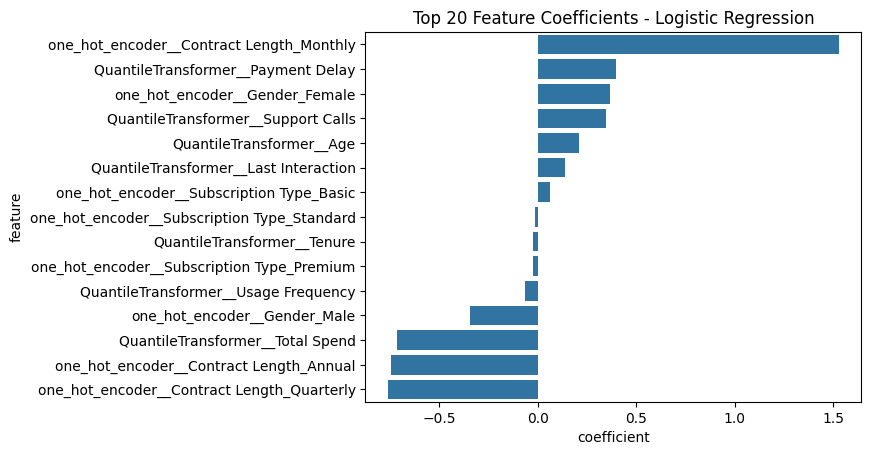

In [21]:
best_lr_pipeline=lr_search.best_estimator_
best_lr=best_lr_pipeline.named_steps['model']
encoder=best_lr_pipeline.named_steps['preprocessor']
feature_names = encoder.get_feature_names_out()

coef=best_lr.coef_[0]
importances_df=pd.DataFrame(
    {
        'feature':feature_names,
        'coefficient':coef

    }
)
plt.Figure(figsize=(10,6))
sns.barplot(data=importances_df.sort_values(by='coefficient',ascending=False).head(20),x='coefficient',y='feature')
plt.title("Top 20 Feature Coefficients - Logistic Regression")
plt.show()

In [22]:
def get_feature_name():
    feature_names = []
    for name, trans, cols in encoder.transformers_:
        if trans == 'drop':
            continue
        elif trans == 'passthrough':
     
            feature_names.extend(cols)
        else:
       
            try:
                feature_names.extend(trans.get_feature_names_out(cols))
            except AttributeError:
           
                feature_names.extend(cols)
    return feature_names  


## Random Forest Classifier

### Finding best hyperparamters

In [23]:
from sklearn.model_selection import HalvingRandomSearchCV
rf_model=RandomForestClassifier(max_samples=0.7)
rf_pipeline=Pipeline(
    steps=[
    ("preprocessor",preprocessor),
    ("model",rf_model)
    ],memory='./cachedir'
)
param_dist={
    'model__n_estimators':[50,100,300],
    'model__min_samples_split':[2,5,10],
    'model__min_samples_leaf':[1,2,4],
    "model__max_depth": [10, 20,30, None],
    "model__max_features": ["sqrt", "log2"]
}
rf_search=HalvingRandomSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    cv=3,
    n_jobs=-1,
    scoring='f1_macro'
)
rf_search.fit(X_train,y_train)
y_pred=rf_search.predict(X_test)
print(classification_report(y_test,y_pred))

C:\Users\nikhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 216 is smaller than n_iter=33680. Running 216 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


              precision    recall  f1-score   support

       False       0.99      0.86      0.92     44943
        True       0.90      1.00      0.94     56099

    accuracy                           0.93    101042
   macro avg       0.95      0.93      0.93    101042
weighted avg       0.94      0.93      0.93    101042



In [24]:
y_proba=rf_search.predict_proba(X_test)[:,1]
roc_auc=roc_auc_score(y_test,y_proba)
con_matrix=confusion_matrix(y_test,y_pred)
print("roc-auc score",roc_auc)
print("confusion matrix",con_matrix)

roc-auc score 0.9525979729248243
confusion matrix [[38494  6449]
 [  226 55873]]


In [25]:
rf_search.best_estimator_

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",'./cachedir'
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('one_hot_encoder', ...), ('QuantileTransformer', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the out

In [26]:
rf_search.best_params_

{'model__n_estimators': 300,
 'model__min_samples_split': 2,
 'model__min_samples_leaf': 2,
 'model__max_features': 'sqrt',
 'model__max_depth': None}

### Developing Model based on the best hyperparameter

In [27]:
best_params=rf_search.best_params_
clean_param={k.replace("model__", ""): v for k, v in best_params.items()}
best_rf=RandomForestClassifier(**clean_param)
best_rf_pipe=Pipeline(
    steps=[
    ("preprocessor",preprocessor),
    ("model",best_rf)
    ],memory='./cachedir'
)
best_rf_pipe.fit(X_train,y_train)
print(classification_report(y_test,best_rf_pipe.predict(X_test)))


              precision    recall  f1-score   support

       False       1.00      0.86      0.92     44943
        True       0.90      1.00      0.94     56099

    accuracy                           0.93    101042
   macro avg       0.95      0.93      0.93    101042
weighted avg       0.94      0.93      0.93    101042



In [28]:
y_proba=best_rf_pipe.predict_proba(X_test)[:,1]
roc_auc=roc_auc_score(y_test,y_proba)
con_matrix=confusion_matrix(y_test,y_pred)
print("roc-auc score",roc_auc)
print("confusion matrix",con_matrix)

roc-auc score 0.9523835134613747
confusion matrix [[38494  6449]
 [  226 55873]]


### Model interpretability and Feature importance

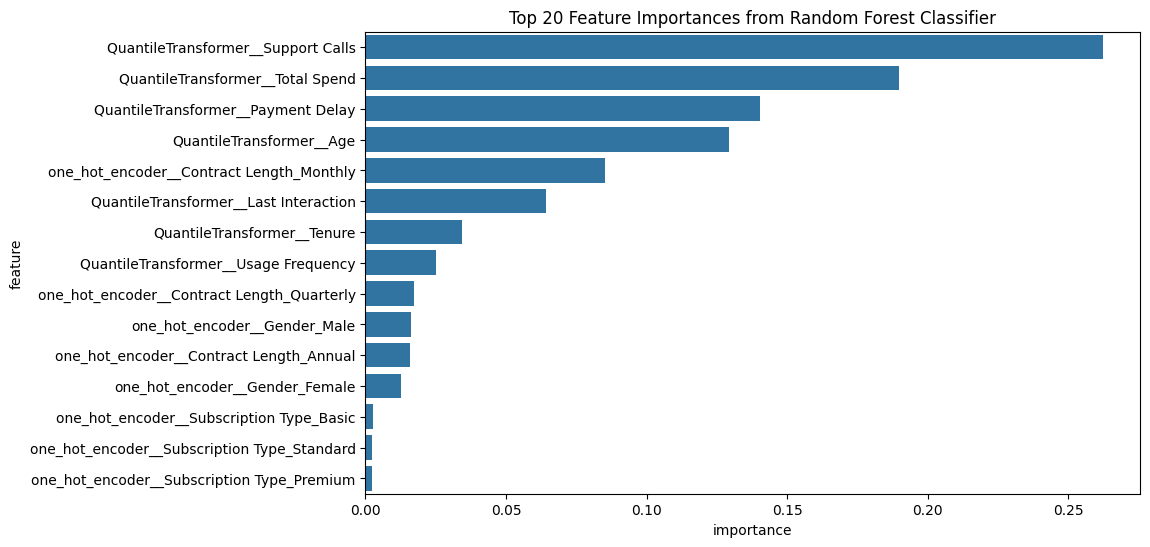

In [ ]:
best_rf=best_rf_pipe.named_steps['model']
encoder=best_rf_pipe.named_steps['preprocessor']
feature_names=encoder.get_feature_names_out()
feature_importance=best_rf.feature_importances_
df_feature_importance=pd.DataFrame({
    'feature':feature_names,
    'importance':feature_importance
})
df_feature_importance.sort_values(by='importance',ascending=False,inplace=True)
plt.figure(figsize=(10,6))
sns.barplot(data=df_feature_importance.head(20),x='importance',y='feature')
plt.title("Top 20 Feature Importances from Random Forest Classifier")
plt.show()
plt.savefig()

## XG Boost 

### Finding best hyperparameters

In [30]:
from sklearn.model_selection import HalvingRandomSearchCV
xg_model=XGBClassifier()
xg_pipe=Pipeline( 
    steps=[
    ("preprocessor",preprocessor),
    ("model",xg_model)
    ],memory='./cachedir'
)
xgb_dist={ 'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6, 10],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__scale_pos_weight': [1, 5, 10],}
xg_search=HalvingRandomSearchCV(
    estimator=xg_pipe,
    param_distributions=xgb_dist,
    cv=3,
    n_jobs=-1,
    scoring='f1'
)
xg_search.fit(X_train,y_train)
y_pred=xg_search.predict(X_test)
print(classification_report(y_test,y_pred))

C:\Users\nikhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 216 is smaller than n_iter=33680. Running 216 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


              precision    recall  f1-score   support

       False       1.00      0.85      0.92     44943
        True       0.90      1.00      0.94     56099

    accuracy                           0.94    101042
   macro avg       0.95      0.93      0.93    101042
weighted avg       0.94      0.94      0.93    101042



In [31]:
y_proba=xg_search.predict_proba(X_test)[:,1]
roc_auc=roc_auc_score(y_test,y_proba)
con_matrix=confusion_matrix(y_test,y_pred)
print("roc-auc score",roc_auc)
print("confusion matrix",con_matrix)

roc-auc score 0.9534084701135886
confusion matrix [[38419  6524]
 [   23 56076]]


### Developing model based on the best hyper parameter

In [32]:
best_params=xg_search.best_params_
clean_param={k.replace("model__",""):v for k,v in best_params.items()}
best_xgb=XGBClassifier(**clean_param)
best_xgb_pipe=Pipeline(
    steps=[
    ("preprocessor",preprocessor),
    ("model",best_xgb)
    ],memory='./cachedir'
)
best_xgb_pipe.fit(X_train,y_train)
print(classification_report(y_test,best_xgb_pipe.predict(X_test)))

              precision    recall  f1-score   support

       False       1.00      0.85      0.92     44943
        True       0.90      1.00      0.94     56099

    accuracy                           0.94    101042
   macro avg       0.95      0.93      0.93    101042
weighted avg       0.94      0.94      0.93    101042



### Model interpretability and Feature importance

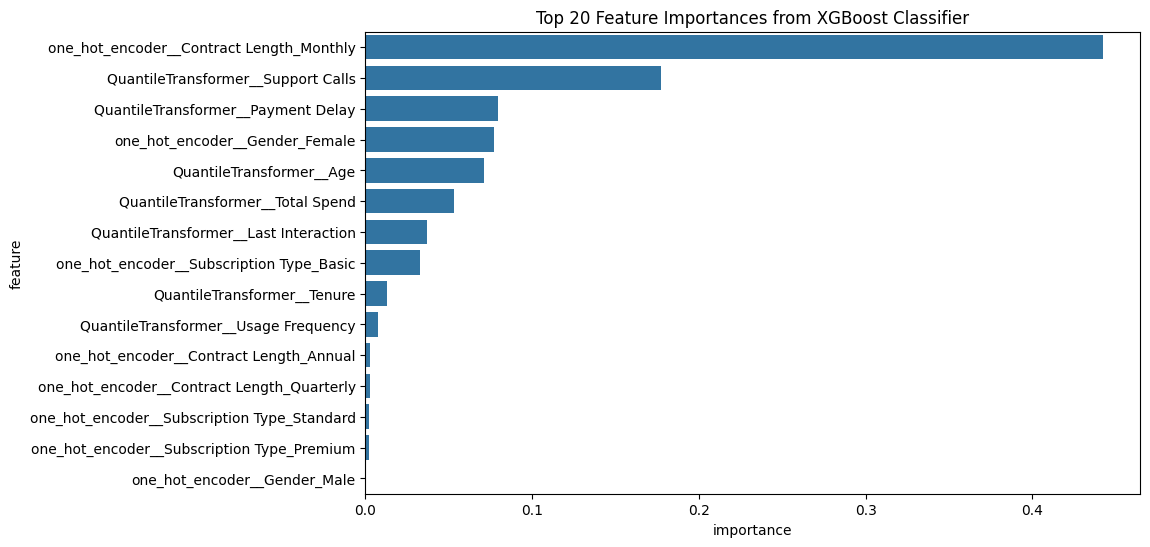

In [33]:
best_xg=best_xgb_pipe.named_steps['model']
features=best_xgb.feature_importances_
feature_names=best_xgb_pipe.named_steps['preprocessor'].get_feature_names_out() 
importances_df=pd.DataFrame({
    'feature':feature_names,
    'importance':features
})
importances_df.sort_values(by='importance',ascending=False,inplace=True)
plt.figure(figsize=(10,6))
sns.barplot(data=importances_df.head(20),x='importance',y='feature')
plt.title("Top 20 Feature Importances from XGBoost Classifier")
plt.show()

## SHAP 

In [34]:
import shap
import numpy
X_train_enc=preprocessor.fit_transform(X_train)
X_test_enc=preprocessor.transform(X_test)
cat_col_names = preprocessor.named_transformers_['one_hot_encoder'].get_feature_names_out()
feature_names=np.concatenate([cat_col_names, numerical])
xgb_explainer = shap.TreeExplainer(best_xgb)
xgb_shap_values = xgb_explainer(X_test_enc)

# Global importance bar plot
shap.plots.bar(xgb_shap_values,feature_names=feature_names, max_display=20)

ImportError: Numba needs NumPy 2.3 or less. Got NumPy 2.4.

## Saving the best model and preprocessor

In [ ]:
import joblib
import json
from datetime import datetime
import os


BASE_DIR = os.path.dirname(os.getcwd())  
MODEL_DIR = os.path.join(BASE_DIR, "model_and_dev")

# Build paths relative to BASE_DIR  
model_path = os.path.join(MODEL_DIR, "model_v1.pkl")
preprocessor_path = os.path.join(MODEL_DIR, "preprocessor.pkl")
metadata_path = os.path.join(MODEL_DIR, "metadata.json")

# Save files
joblib.dump(best_xgb_pipe, model_path)
joblib.dump(preprocessor, preprocessor_path)

metadata = {
    "model_version": "v1",
    "trained_on": "customer_churn_dataset",
    "metric": "ROC-AUC ",
    "score": 0.95,
    "trained_at": datetime.now().isoformat()
}

with open(metadata_path, "w") as f:
    json.dump(metadata, f)

# Notebook Summary and Stakeholder Narrative